In [93]:
import torch
import torchvision
import random
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

PATH = './emnist.pth'

## Download/load data

In [6]:
transform = T.Compose(
    [
        T.ToTensor(),
        # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 5

train_set = torchvision.datasets.EMNIST(
    root='./data',
    split="byclass",
    train=True,
    download=True, 
    transform=transform
)

test_set = torchvision.datasets.EMNIST(
    root='./data', 
    split="byclass",
    train=False,
    download=True, 
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = train_loader.dataset.class_to_idx
number_of_classes = len(classes.keys())

def get_class_name(class_index):
    for name, index in classes.items():
        if index == class_index:
            return name

## Visualizing classes

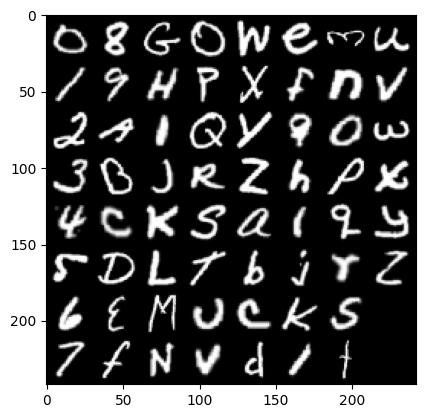

0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z


In [7]:
def imshow(img):
    # img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (2, 1, 0)))
    plt.show()

images = []
for cls in classes.values():
    for img, label in train_set:
        if label == cls:            
            images.append(img)
            break

imshow(torchvision.utils.make_grid(images))
print(' '.join(classes.keys()))

## CNN Definition

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_of_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

In [147]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.300
[1,  4000] loss: 1.023
[1,  6000] loss: 0.907
[1,  8000] loss: 0.820
[1, 10000] loss: 0.754
[1, 12000] loss: 0.736
[1, 14000] loss: 0.694
[1, 16000] loss: 0.676
[1, 18000] loss: 0.647
[1, 20000] loss: 0.632
[1, 22000] loss: 0.635
[1, 24000] loss: 0.622
[1, 26000] loss: 0.619
[1, 28000] loss: 0.581
[1, 30000] loss: 0.575
[1, 32000] loss: 0.569
[1, 34000] loss: 0.581
[1, 36000] loss: 0.558
[1, 38000] loss: 0.555
[1, 40000] loss: 0.551
[1, 42000] loss: 0.546
[1, 44000] loss: 0.545
[1, 46000] loss: 0.539
[1, 48000] loss: 0.533
[1, 50000] loss: 0.530
[1, 52000] loss: 0.510
[1, 54000] loss: 0.538
[1, 56000] loss: 0.512
[1, 58000] loss: 0.514
[1, 60000] loss: 0.501
[1, 62000] loss: 0.511
[1, 64000] loss: 0.505
[1, 66000] loss: 0.507
[1, 68000] loss: 0.494
[1, 70000] loss: 0.495
[1, 72000] loss: 0.524
[1, 74000] loss: 0.503
[1, 76000] loss: 0.512
[1, 78000] loss: 0.482
[1, 80000] loss: 0.496
[1, 82000] loss: 0.508
[1, 84000] loss: 0.473
[1, 86000] loss: 0.498
[1, 88000] 

## Saving trained network

In [148]:
torch.save(net.state_dict(), PATH)

## Loading trained network

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Testing the network

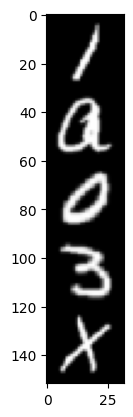

GroundTruth:  I a 0 3 X
Predicted:  1 a 0 3 X


In [143]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(get_class_name(label) for label in labels))

outputs = net(images)
_, predicted_labels = torch.max(outputs, 1)

print('Predicted: ', ' '.join(get_class_name(label) for label in predicted_labels))

In [156]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 84 %


In [157]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes.keys()}
total_pred = {classname: 0 for classname in classes.keys()}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[get_class_name(label)] += 1
            total_pred[get_class_name(label)] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 86.2 %
Accuracy for class: 1     is 90.2 %
Accuracy for class: 2     is 94.6 %
Accuracy for class: 3     is 98.9 %
Accuracy for class: 4     is 96.4 %
Accuracy for class: 5     is 91.1 %
Accuracy for class: 6     is 98.4 %
Accuracy for class: 7     is 98.8 %
Accuracy for class: 8     is 97.7 %
Accuracy for class: 9     is 97.5 %
Accuracy for class: A     is 91.6 %
Accuracy for class: B     is 83.2 %
Accuracy for class: C     is 96.3 %
Accuracy for class: D     is 86.6 %
Accuracy for class: E     is 93.9 %
Accuracy for class: F     is 79.8 %
Accuracy for class: G     is 81.7 %
Accuracy for class: H     is 89.8 %
Accuracy for class: I     is 52.5 %
Accuracy for class: J     is 90.6 %
Accuracy for class: K     is 81.7 %
Accuracy for class: L     is 94.3 %
Accuracy for class: M     is 92.0 %
Accuracy for class: N     is 96.2 %
Accuracy for class: O     is 46.0 %
Accuracy for class: P     is 93.3 %
Accuracy for class: Q     is 82.3 %
Accuracy for class: R     is

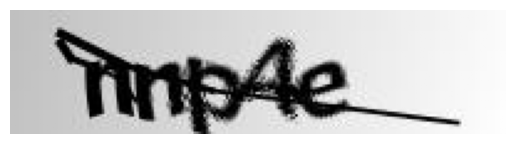

nnp4e


In [157]:
captchas = os.listdir('./captcha_dataset')
def get_random_captcha():
    selected_captcha = captchas[random.randint(0, len(captchas))]
    solution = selected_captcha[0:-4]

    image_path = os.path.join("./captcha_dataset", selected_captcha)
    image = plt.imread(image_path)
    return image, solution

captcha, solution = get_random_captcha()
plt.imshow(captcha)
plt.axis('off')
plt.show()
print(solution)

In [158]:
def process_captcha(captcha, break_into: int):
    flattened_captcha = np.mean(captcha, axis=2)
    broken_images = []
    starting = 0
    step = int(200 / break_into)
    ending = step
    for _ in range(break_into):
        piece = flattened_captcha[:, starting: ending]
        piece = piece[np.newaxis, :, :]
        piece = torch.Tensor(piece)
        piece = T.Resize(size = (28, 28), antialias=True)(piece)

        broken_images.append(piece.numpy())
        starting += step
        ending += step
    return torch.Tensor(np.array(broken_images))


broken_images = process_captcha(captcha, 5)

# fig, axs = plt.subplots(1, 5, figsize=(15, 3))
# for i, part in enumerate(broken_images):
#     axs[i].imshow(part.numpy().reshape(28,28), cmap='gray')
#     axs[i].axis('off')

In [160]:
with torch.no_grad():
    prediction = []
    outputs = net(broken_images)
    _, predicted = torch.max(outputs.data, 1)
    
print('Predicted:', ''.join(get_class_name(label) for label in predicted))
print(f'Actual: {solution}')

Predicted: eFRee
Actual: nnp4e
